# OFFLINE PATH PLANNING OPTIMISATION
This notebook elaborates the testing and development of an offline path planning optimisation pipeline to generate a safe and feasible reference path for a ego vehicle. The pipeline takes a set of coarsely placed waypoints and adjusts their localisation so as to comply with certain path curvature constraints in view of the vehicle's size and steering capability. The adjusted waypoints should be as close as possible to the original waypoints without violating the curvature constraints.

### Installation
Before beginning, it is important to install all the dependencies to run all cells in this notebook.

!pip install -r requirements.txt

### Imports

In [ ]:
import numpy as np
import pandas as pd
import scipy.optimize as optimize

from scipy.interpolate import CubicSpline
from numba import njit

### Generating Waypoints
To easily generate waypoints for testing, we will use a modified version of my [Waypoint Generator](https://github.com/winstxnhdw/WaypointGenerator) script. The generated waypoints are exported as a CSV file and can be imported again using the pandas library.

In [ ]:
%matplotlib widget

import matplotlib.pyplot as plt

class ClickGenerator:

    def __init__(self, ax, fig, map_size, line_colour, point_colour):
        
        self.x = []
        self.y = []

        self.ax = ax
        self.fig = fig
        self.map_size = map_size
        self.line_colour = line_colour
        self.point_colour = point_colour

    def generate(self):

        def onclick(event):

            self.x.append(event.xdata)
            self.y.append(event.ydata)

            self.ax.plot(self.x, self.y, '-', color=self.line_colour)
            self.ax.plot(self.x, self.y, '.', color=self.point_colour)

            self.fig.canvas.draw()

            axis = {'X-axis': self.x, 'Y-axis': self.y}
            df = pd.DataFrame(axis, columns= ['X-axis', 'Y-axis'])
            df.to_csv("waypoints.csv", index = False)

        def onpress(event):

            # Undo last point
            if event.key == 'z':
                try:
                    self.x.pop()
                    self.y.pop()

                except:
                    pass
            
            # Clear all the points
            elif event.key == 'x':
                del self.x[:]
                del self.y[:]

            # Connect the first and last points
            elif event.key == 'c':
                try:
                    self.x.append(self.x[0])
                    self.y.append(self.y[0])

                except:
                    pass
        
            else:
                pass
        
            plt.cla()
            plt.grid()
            self.ax.set_xlim(-self.map_size, self.map_size)
            self.ax.set_ylim(-self.map_size, self.map_size)
            self.ax.plot(self.x, self.y, '-', color=self.line_colour)
            self.ax.plot(self.x, self.y, '.', color=self.point_colour)
            self.fig.canvas.draw()

            axis = {'X-axis': self.x, 'Y-axis': self.y}
            df = pd.DataFrame(axis, columns= ['X-axis', 'Y-axis'])
            df.to_csv("waypoints.csv", index = False)

        self.fig.canvas.mpl_connect('button_press_event', onclick)
        self.fig.canvas.mpl_connect('key_press_event', onpress)

def main():

    # Parameters
    map_size = 100
    line_colour = '#F0A39A'
    point_colour = '#383831'

    fig = plt.figure()
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.resizable = True
    
    ax = plt.axes()
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(-map_size, map_size)
    ax.set_ylim(-map_size, map_size)

    click_gen = ClickGenerator(ax, fig, map_size, line_colour, point_colour)
    click_gen.generate()

    plt.grid()
    plt.show()

if __name__ == '__main__':
    main()

### Importing the Generated Waypoints

In [ ]:
dir_path = 'waypoints.csv'
df = pd.read_csv(dir_path)
wx = df['X-axis'].values.tolist()
wy = df['Y-axis'].values.tolist()

## Optimisation #1: Levenberg–Marquardt Algorithm
The paper describing the usage of the algorithm can be found [here](https://www.ri.cmu.edu/pub_files/2013/6/IV2013-Tianyu.pdf).

### Constructing the Seeding Path

In [43]:
from bisect import bisect

class Spline:

    def __init__(self, x, y):
        
        self.x = x
        self.y = y

        self.a = y
        self.b = []
        self.d = []

        dim_size = len(max(x, y))
        h = np.diff(x)

        A = self.matrixA(h, dim_size)
        B = self.matrixB(h, dim_size)
        self.c = np.linalg.solve(A, B)

        for i in range(dim_size - 1):
            self.b.append((self.a[i + 1] - self.a[i])/h[i] - h[i]*(self.c[i + 1] + 2.0*self.c[i]) / 3.0)
            self.d.append((self.c[i + 1] - self.c[i]) / (3.0 * h[i]))

    def matrixA(self, h, size):
        
        A = np.zeros((size, size))
        A[0, 0] = 1.0

        for i in range(size - 1):
            if i != (size - 2):
                A[i + 1, i + 1] = 2.0 * (h[i] + h[i + 1])

            A[i + 1, i] = h[i]
            A[i, i + 1] = h[i]

        A[0, 1] = 0.0
        A[size - 1, size - 2] = 0.0
        A[size - 1, size - 1] = 1.0

        return A

    def matrixB(self, h, size):
        
        B = np.zeros(size)

        for i in range(size - 2):
            B[i + 1] = 3.0 * (self.a[i + 2] - self.a[i + 1]) / h[i + 1] - 3.0 * (self.a[i + 1] - self.a[i]) / h[i]
            
        return B

    def solve_function(self, x):
        
        if x < self.x[0]:
            return None

        elif x > self.x[-1]:
            return None

        else:
            i = self.search_index(x)
            deltax = x - self.x[i]
            result = self.a[i] + self.b[i]*deltax + self.c[i]*deltax**2.0 + self.d[i]*deltax**3.0

            return result

    def solve_1st_derivative(self, x):
        
        if x < self.x[0]:
            return None

        elif x > self.x[-1]:
            return None

        else:
            i = self.search_index(x)
            deltax = x - self.x[i]
            result = self.b[i] + 2.0*self.c[i]*deltax + 3.0*self.d[i]*deltax**2.0

            return result

    def solve_2nd_derivative(self, x):
        
        if x < self.x[0]:
            return None

        elif x > self.x[-1]:
            return None

        else:
            i = self.search_index(x)
            deltax = x - self.x[i]
            result = 2.0*self.c[i] + 6.0*self.d[i] * deltax

            return result

    def search_index(self, x):

        i = bisect(self.x, x) - 1

        return i

class Spline2D:

    def __init__(self, x, y):

        self.ds = None

        self.s = self.calculate_s(x, y)
        self.sx = Spline(self.s, x)
        self.sy = Spline(self.s, y)

    def calculate_s(self, x, y):
        
        deltax = np.diff(x)
        deltay = np.diff(y)
        self.ds = np.hypot(deltax, deltay)

        s = [0]
        s.extend(np.cumsum(self.ds))

        return s

    def calculate_position(self, s):
        
        x = self.sx.solve_function(s)
        y = self.sy.solve_function(s)

        return x, y

    def calculate_yaw(self, s):
        
        dx = self.sx.solve_1st_derivative(s)
        dy = self.sy.solve_1st_derivative(s)
        yaw = np.arctan2(dy, dx)

        return yaw

    def calculate_curvature(self, s):
        
        dx = self.sx.solve_1st_derivative(s)
        ddx = self.sx.solve_2nd_derivative(s)
        dy = self.sy.solve_1st_derivative(s)
        ddy = self.sy.solve_2nd_derivative(s)

        k = (ddy*dx - ddx*dy) / ((dx**2 + dy**2)**(3 / 2))

        return k

def generate_cubic_path(x, y, ds=0.05):

    sp2d = Spline2D(x, y)
    s = np.arange(0, sp2d.s[-1], ds)

    px = []
    py = []
    pyaw = []
    pk = []

    for i in s:
        ix, iy = sp2d.calculate_position(i)
        px.append(ix)
        py.append(iy)
        pyaw.append(sp2d.calculate_yaw(i))
        pk.append(sp2d.calculate_curvature(i))

    return px, py, pyaw, pk

In [45]:
df = pd.read_csv(dir_path)
x = df['X-axis'].values.tolist()
y = df['Y-axis'].values.tolist()

px, py, pyaw, pk = generate_cubic_path(x, y)

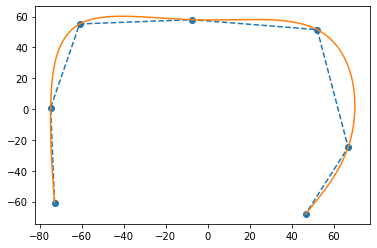

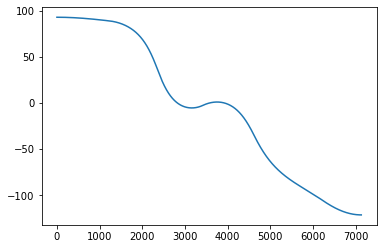

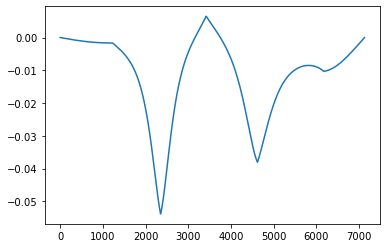

In [46]:
%matplotlib inline

plt.figure(1)
plt.plot(x, y, '--o')
plt.plot(px, py)

plt.figure(2)
plt.plot(np.rad2deg(pyaw))

plt.figure(3)
plt.plot(pk)

### Optimise Path

### Export Notebook as Markdown

!jupyter nbconvert main.ipynb --to markdown --output README.md